# Set Darwin SDK

In [1]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')

ModuleNotFoundError: No module named 'amb_sdk'

# Environment Variables

In [2]:
#Set your user id and password accordingly
USER="jggammack@gmail.com"
PW="q8bMeteRPg"

# Modify accordingly if you wish to use your own data

# A timestamp is used to create a unique name in the event you execute the workflow multiple times or with 
# different datasets.  File names must be unique in Darwin.
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

# All Imports

In [3]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Logs In

In [4]:
status, msg = ds.auth_login_user(USER,PW)
if not status:
    print(msg)

# Upload Data and Clean

**Read Combined Dataset**

Separate data into a training dataset and testing dataset using test_size = 0.2

In [5]:
Undersampled_Dataset = pd.read_csv('Undersampled Dataset AV.csv',low_memory=False)
TRAIN_DATASET, TEST_DATASET = train_test_split(Undersampled_Dataset,test_size=0.2)
print(TRAIN_DATASET.shape)
print(TEST_DATASET.shape)
TRAIN_DATASET.to_csv('TRAIN_DATASET.csv',index=False)
TEST_DATASET.to_csv('TEST_DATASET.csv',index=False)
TRAIN_DATASET = 'TRAIN_DATASET.csv'
TEST_DATASET = 'TEST_DATASET.csv'
Undersampled_Dataset.head()

(3587, 13)
(897, 13)


,Accident_Severity,Age_Band_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Road_Type,Sex_of_Driver,Special_Conditions_at_Site,Speed_limit,Towing_and_Articulation,Urban_or_Rural_Area,Vehicle_Type,Weather_Conditions
0,1.0,5.0,1.0,4.0,1.0,6.0,1.0,0.0,30.0,0.0,1.0,9.0,1.0
1,1.0,7.0,1.0,1.0,4.0,6.0,1.0,0.0,30.0,0.0,1.0,20.0,1.0
2,1.0,8.0,2.0,1.0,4.0,6.0,1.0,0.0,30.0,0.0,1.0,3.0,1.0
3,1.0,10.0,3.0,4.0,1.0,3.0,1.0,0.0,40.0,0.0,1.0,19.0,1.0
4,1.0,8.0,4.0,4.0,1.0,3.0,1.0,0.0,40.0,0.0,1.0,5.0,1.0


In [6]:
# Preview dataset
df = pd.read_csv(TRAIN_DATASET)
print(df.shape)
df.head()

(3587, 13)


,Accident_Severity,Age_Band_of_Driver,Age_of_Vehicle,Light_Conditions,Road_Surface_Conditions,Road_Type,Sex_of_Driver,Special_Conditions_at_Site,Speed_limit,Towing_and_Articulation,Urban_or_Rural_Area,Vehicle_Type,Weather_Conditions
0,3.0,6.0,3.0,1.0,1.0,6.0,2.0,0.0,30.0,0.0,1.0,9.0,1.0
1,1.0,4.0,4.0,1.0,1.0,6.0,1.0,0.0,60.0,0.0,2.0,9.0,1.0
2,1.0,9.0,1.0,4.0,2.0,6.0,1.0,0.0,30.0,1.0,2.0,21.0,2.0
3,1.0,9.0,2.0,1.0,1.0,6.0,1.0,0.0,60.0,0.0,2.0,5.0,1.0
4,3.0,5.0,2.0,1.0,1.0,3.0,2.0,0.0,30.0,0.0,1.0,9.0,1.0


**Upload Dataset to Darwin**

In [7]:
# Upload dataset
ds.delete_all_datasets()
status, dataset = ds.upload_dataset(TRAIN_DATASET)
if not status:
    print(dataset)
ds.lookup_dataset()

Deleting TRAIN_DATASET.csv
Deleting TEST_DATASET.csv


(True,
 [{'name': 'TRAIN_DATASET.csv',
   'mbytes': 0.1858081817626953,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-05-05T20:00:59.843246',
   'categorical': None,
   'sequential': None,
   'imbalanced': None}])

**Clean Dataset**

In [8]:
# clean dataset
target = "Accident_Severity"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)

if status:
    ds.wait_for_job(job_id['job_name'],time_limit=1800)
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-05-05T20:01:00.982911', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': ['4d62bc55b0414e6c94e60e1e2f52e770'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-05-05T20:01:00.982911', 'endtime': '2019-05-05T20:01:05.758385', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': ['4d62bc55b0414e6c94e60e1e2f52e770'], 'model_name': None, 'job_error': ''}


# Create and Train Model 

We will now build a model that will learn the class labels in the target column.<br> In the dataset, the target column is "Accident_Severity". <br> 


In [9]:
model = target + "_model0" + ts
ds.delete_model(model)
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET, \
                                 model_name =  model, \
                                 max_train_time = '00:30')
if status:
    ds.wait_for_job(job_id['job_name'],time_limit=1800)
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-05-05T20:01:17.319293', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': None}
{'status': 'Running', 'starttime': '2019-05-05T20:01:17.319293', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': 0.6128493547439575, 'generations': 4, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-05-05T20:01:17.319293', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': 0.6128493547439575, 'generations': 4, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-05-05T20:01:17.319293', 'en

# Extra Training
Run the following cell for extra training, no need to specify parameters

In [10]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = TRAIN_DATASET,
                                          model_name = model,
                                          max_train_time = '00:30')
                                          
if status:
    ds.wait_for_job(job_id['job_name'],time_limit=1800)
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-05-05T20:03:34.04274', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.6128493547439575, 'generations': 4, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': None}
{'status': 'Running', 'starttime': '2019-05-05T20:03:34.04274', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-05-05T20:03:34.04274', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': None, 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-05-05T20:03:3

# Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [11]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'],time_limit=1800)
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-05-05T20:05:35.719359', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': None, 'artifact_names': ['f40bb15ed0fb4f599695ea7e537d74ef'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-05-05T20:05:35.719359', 'endtime': '2019-05-05T20:05:38.363878', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': None, 'artifact_names': ['f40bb15ed0fb4f599695ea7e537d74ef'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}


Show the 10 most important features of the model.

In [22]:
feature_importance[:]

Speed_limit = 30.0                  2.521076e-01
Urban_or_Rural_Area = 2.0           2.290131e-01
Speed_limit = 60.0                  1.154961e-01
Vehicle_Type = 5.0                  4.549620e-02
Vehicle_Type = 21.0                 3.651953e-02
Sex_of_Driver = 2.0                 3.438531e-02
Light_Conditions = 6.0              2.948037e-02
Light_Conditions = 4.0              2.194067e-02
Speed_limit = 40.0                  2.154502e-02
Speed_limit = 50.0                  1.881343e-02
Road_Type = 6.0                     1.799933e-02
Road_Type = 3.0                     1.766510e-02
Speed_limit = 70.0                  1.511270e-02
Vehicle_Type = 9.0                  1.491604e-02
Weather_Conditions = 2.0            1.175039e-02
Age_Band_of_Driver = 5.0            1.078265e-02
Age_of_Vehicle = 2.0                1.037542e-02
Towing_and_Articulation = 1.0       9.868593e-03
Road_Surface_Conditions = 2.0       9.525706e-03
Age_of_Vehicle = 4.0                8.354034e-03
Age_of_Vehicle = 3.0

In [ ]:
x=['Speed limit = 30 mph','Rural Area','Speed limit = 60 mph','Large Motorcycle','Large Semi-Truck','Female Driver','Dark Lighting']
y=[2.521076e-01,2.290131e-01,1.154961e-01,4.549620e-02,3.651953e-02,3.438531e-02,2.948037e-02]
plt.bar(x,y)

# Predictions
**Perform model prediction on the the training dataset.**

In [13]:
status, artifact = ds.run_model(TRAIN_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'],time_limit=1800)

{'status': 'Running', 'starttime': '2019-05-05T20:05:53.491763', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': ['ba5a95f9d15b439699bc483a2265193d'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-05-05T20:05:53.491763', 'endtime': '2019-05-05T20:05:55.305056', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TRAIN_DATASET.csv'], 'artifact_names': ['ba5a95f9d15b439699bc483a2265193d'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}


(True, 'Job completed')

Download predictions from Darwin's server.

In [14]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,Accident_Severity,prob_1.0,prob_3.0
0,3,0.159137,0.840863
1,1,0.736640,0.263360
2,1,0.657031,0.342969
3,1,0.892566,0.107434
4,3,0.123008,0.876992


Create plots comparing predictions with actual target

              precision    recall  f1-score   support

         1.0       0.74      0.72      0.73      1806
         3.0       0.72      0.74      0.73      1781

   micro avg       0.73      0.73      0.73      3587
   macro avg       0.73      0.73      0.73      3587
weighted avg       0.73      0.73      0.73      3587



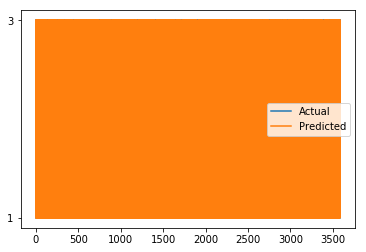

In [15]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

**Perform model prediction on a test dataset that wasn't used in training.** <br>
Upload test dataset

In [16]:
status, dataset = ds.upload_dataset(TEST_DATASET)
if not status:
    print(dataset)

Clean test dataset

In [17]:
# clean test dataset
status, job_id = ds.clean_data(TEST_DATASET, target = target, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'],time_limit=1800)
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-05-05T20:06:13.310578', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['TEST_DATASET.csv'], 'artifact_names': ['e40e16074e1d4e3d8787fb3af4e359f9'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-05-05T20:06:13.310578', 'endtime': '2019-05-05T20:06:15.83128', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['TEST_DATASET.csv'], 'artifact_names': ['e40e16074e1d4e3d8787fb3af4e359f9'], 'model_name': None, 'job_error': ''}


Run model on test dataset.

In [18]:
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'],time_limit=1800)

{'status': 'Running', 'starttime': '2019-05-05T20:06:29.573208', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TEST_DATASET.csv'], 'artifact_names': ['24da97b0e6a444caa984a4f4a840edca'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-05-05T20:06:29.573208', 'endtime': '2019-05-05T20:06:31.424203', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.6128493547439575, 'generations': 7, 'dataset_names': ['TEST_DATASET.csv'], 'artifact_names': ['24da97b0e6a444caa984a4f4a840edca'], 'model_name': 'Accident_Severity_model020190505200045', 'job_error': ''}


(True, 'Job completed')

Create plots comparing predictions with actual target

              precision    recall  f1-score   support

         1.0       0.69      0.65      0.67       436
         3.0       0.68      0.72      0.70       461

   micro avg       0.68      0.68      0.68       897
   macro avg       0.68      0.68      0.68       897
weighted avg       0.68      0.68      0.68       897



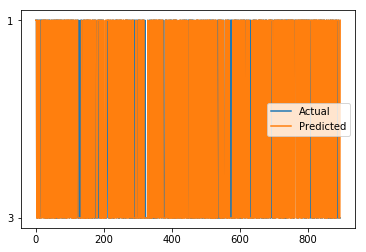

In [19]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(TEST_DATASET)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

## Find out which machine learning model did Darwin use:

In [20]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'RandomForestClassifier', 'parameters': {}}
